In [ ]:
from google.colab import files

# Upload kaggle.json file
files.upload()  # Choose your kaggle.json from your computer



Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"saratusalihu","key":"45fca87d60a3ca2a9ecc45fef4f0f8a7"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!pip install -q kaggle


In [ ]:
# Download and unzip the dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia --unzip -p ./dataset


Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [00:23<00:00, 259MB/s]
100% 2.29G/2.29G [00:23<00:00, 104MB/s]


In [ ]:
import os

base_dir = './dataset/chest_xray'

print("Train folders:", os.listdir(os.path.join(base_dir, 'train')))
print("Test folders:", os.listdir(os.path.join(base_dir, 'test')))


Train folders: ['PNEUMONIA', 'NORMAL']
Test folders: ['PNEUMONIA', 'NORMAL']


In [ ]:
import os
import shutil
import random

# Original dataset paths
original_base = './dataset/chest_xray'
train_dir = os.path.join(original_base, 'train')
test_dir = os.path.join(original_base, 'test')

# New small subset paths
subset_base = './dataset_small'
os.makedirs(subset_base, exist_ok=True)

def create_subset(split):
    for cls in ['PNEUMONIA', 'NORMAL']:
        orig_path = os.path.join(original_base, split, cls)
        subset_path = os.path.join(subset_base, split, cls)
        os.makedirs(subset_path, exist_ok=True)

        # Randomly pick 50 images per class
        images = os.listdir(orig_path)
        random.shuffle(images)
        selected = images[:50]  # you can increase/decrease if needed

        for img in selected:
            shutil.copy(os.path.join(orig_path, img), os.path.join(subset_path, img))

# Create small train/test subsets
create_subset('train')
create_subset('test')

print("Small dataset created at './dataset_small'")


Small dataset created at './dataset_small'


In [ ]:
from google.colab import drive
import shutil
import os

# 1️⃣ Mount Google Drive
drive.mount('/content/drive')

# 2️⃣ Set a path in your Drive
drive_path = '/content/drive/MyDrive/Chest_Xray_Demo'

# 3️⃣ Copy the small dataset to Drive
# Remove the directory if it already exists to avoid FileExistsError
if os.path.exists(drive_path):
    shutil.rmtree(drive_path)
shutil.copytree('./dataset_small', drive_path)

print(f"Small dataset saved to Google Drive at {drive_path}")

Mounted at /content/drive
Small dataset saved to Google Drive at /content/drive/MyDrive/Chest_Xray_Demo


In [ ]:
import os
import cv2
import numpy as np
from glob import glob
from sklearn.utils import shuffle


In [ ]:
def svd_compress_image(image_path, k=50, resize=(224,224)):
    """
    Load an image, convert to grayscale, resize, apply SVD compression, and reconstruct.
    """
    # Load and resize
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, resize)

    # Apply SVD
    U, S, Vt = np.linalg.svd(img, full_matrices=False)
    S_k = np.diag(S[:k])
    U_k = U[:, :k]
    Vt_k = Vt[:k, :]
    img_reconstructed = np.dot(U_k, np.dot(S_k, Vt_k))

    # Normalize to 0-1
    img_reconstructed = img_reconstructed / 255.0
    img_reconstructed = np.expand_dims(img_reconstructed, axis=-1)  # add channel
    return img_reconstructed


In [ ]:
def prepare_dataset(base_path):
    X, y = [], []
    for label, cls in enumerate(['NORMAL', 'PNEUMONIA']):
        folder = os.path.join(base_path, cls)
        images = glob(os.path.join(folder, '*'))
        for img_path in images:
            img = svd_compress_image(img_path, k=50)
            X.append(img)
            y.append(label)
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.int32)
    X, y = shuffle(X, y, random_state=42)
    return X, y

# Prepare train and test
train_path = '/content/drive/MyDrive/Chest_Xray_Demo/train'
test_path = '/content/drive/MyDrive/Chest_Xray_Demo/test'

X_train, y_train = prepare_dataset(train_path)
X_test, y_test = prepare_dataset(test_path)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (100, 224, 224, 1), Test shape: (100, 224, 224, 1)


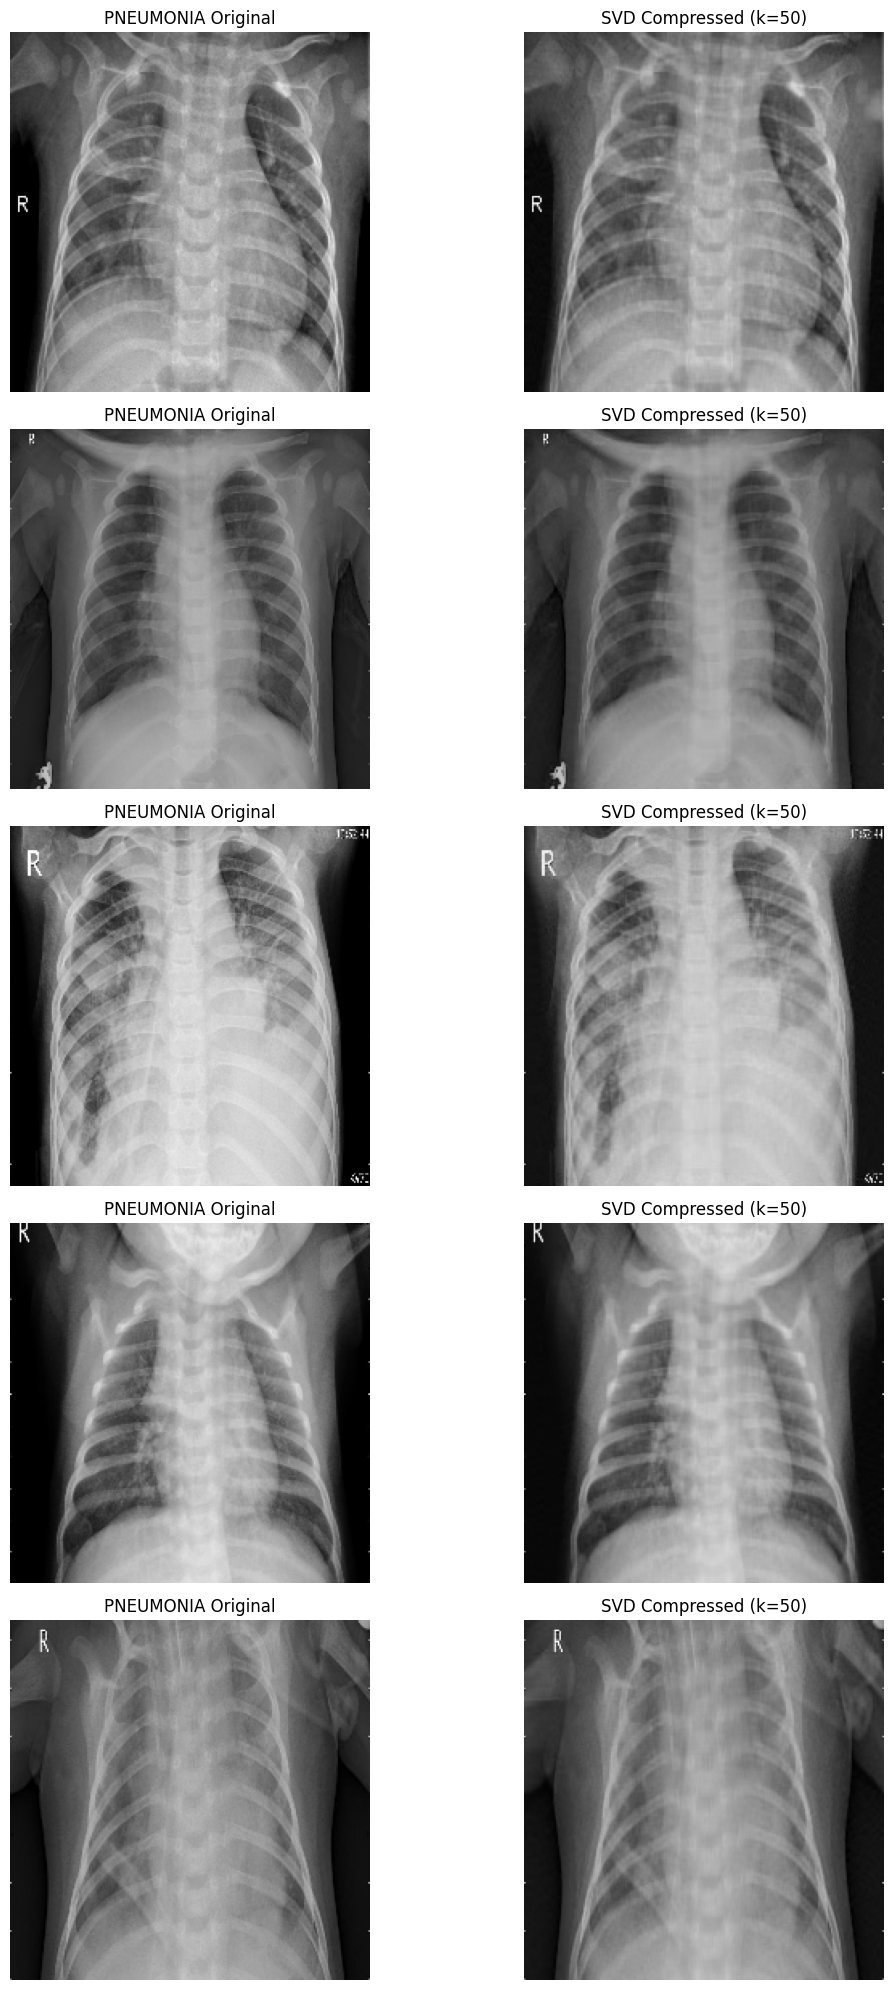

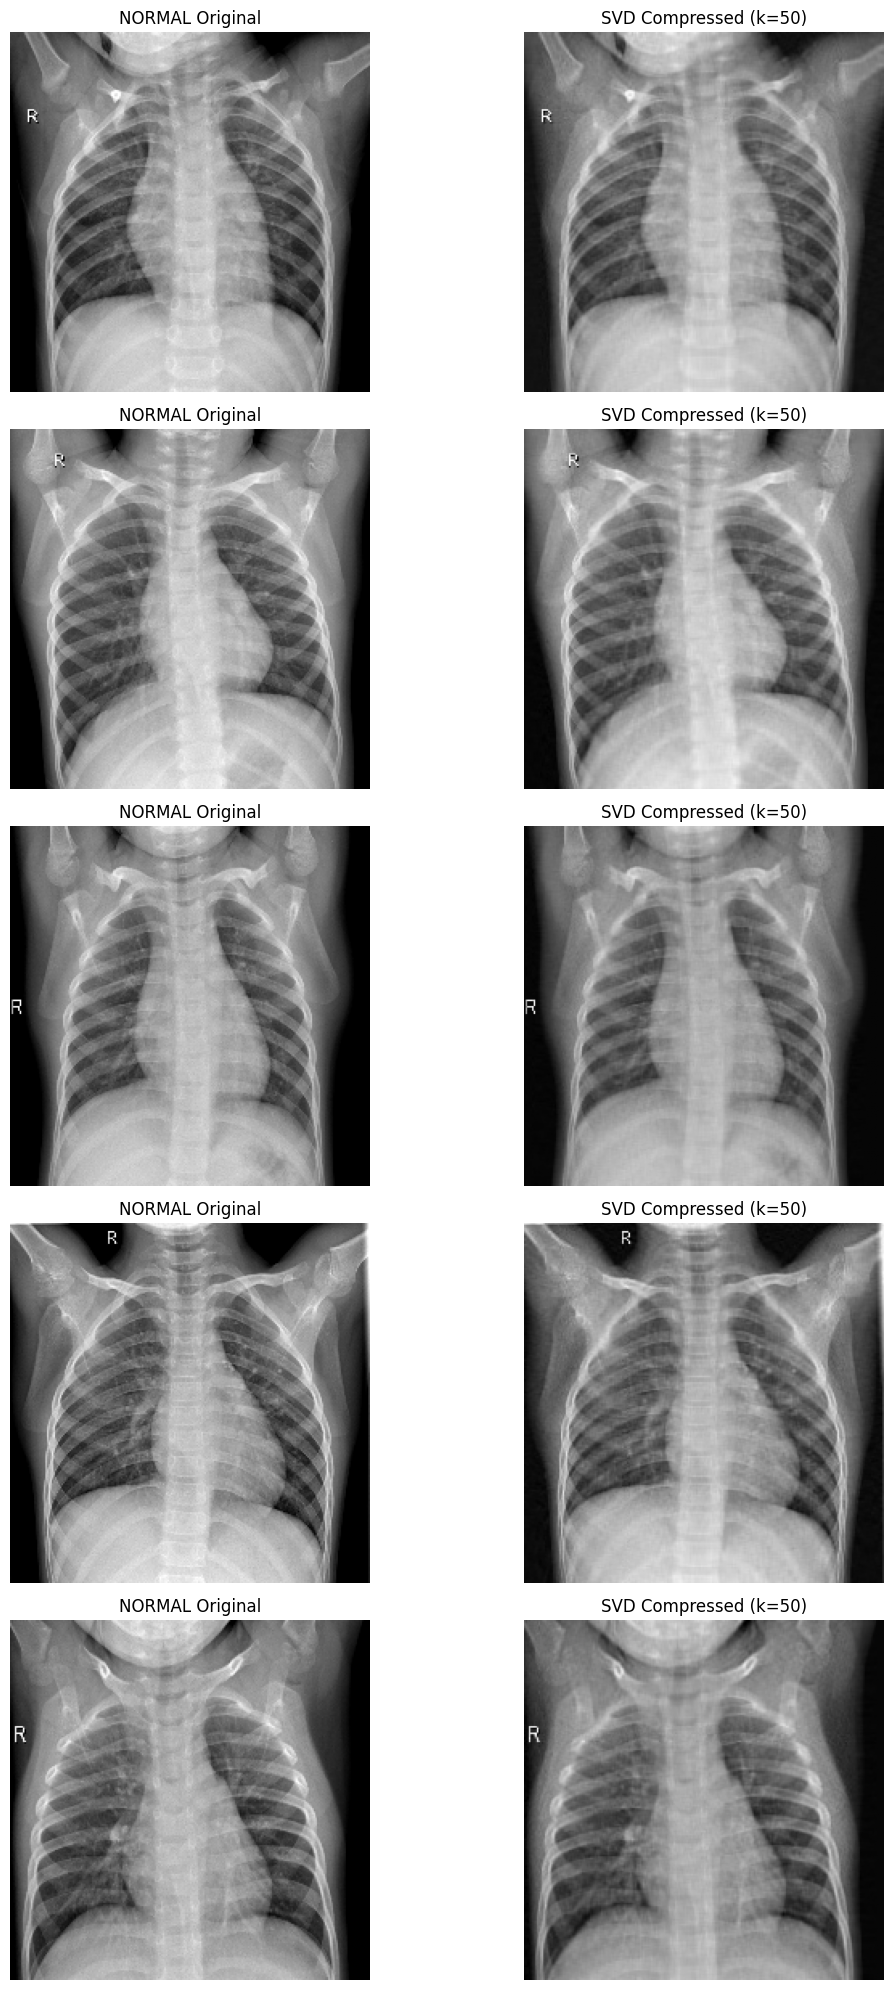

In [ ]:
import matplotlib.pyplot as plt
def visualize_grid(class_name='PNEUMONIA', num_images=5, k=50):
    """
    Visualize original and SVD-compressed images for a given class.
    """
    images = glob(os.path.join(train_path, class_name, '*'))
    selected = random.sample(images, num_images)

    plt.figure(figsize=(12, 4 * num_images))

    for i, img_path in enumerate(selected):
        # Original
        orig = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        orig = cv2.resize(orig, (224,224))

        # SVD
        svd_img = svd_compress_image(img_path, k=k, resize=(224,224)).squeeze()

        # Plot Original
        plt.subplot(num_images, 2, i*2 + 1)
        plt.imshow(orig, cmap='gray')
        plt.title(f'{class_name} Original')
        plt.axis('off')

        # Plot SVD
        plt.subplot(num_images, 2, i*2 + 2)
        plt.imshow(svd_img, cmap='gray')
        plt.title(f'SVD Compressed (k={k})')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example: visualize 5 images from PNEUMONIA and NORMAL
visualize_grid('PNEUMONIA', num_images=5, k=50)
visualize_grid('NORMAL', num_images=5, k=50)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical


In [ ]:
# Convert labels to categorical
y_train_cat = to_categorical(y_train, num_classes=2)
y_test_cat = to_categorical(y_test, num_classes=2)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train_cat.shape)


X_train shape: (100, 224, 224, 1)
y_train shape: (100, 2)


In [ ]:
def build_cnn(input_shape=(224,224,1), num_classes=2):
    model = models.Sequential()

    # Conv Block 1
    model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2,2)))

    # Conv Block 2
    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))

    # Conv Block 3
    model.add(layers.Conv2D(128, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))

    # Flatten + Dense
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Build the model
model = build_cnn()
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,168,642 (42.60 MB)

 Trainable params: 11,168,642 (42.60 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train
history = model.fit(
    X_train, y_train_cat,
    epochs=10,             # small dataset, 10 epochs enough for demo
    batch_size=16,
    validation_data=(X_test, y_test_cat)
)


Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.5004 - loss: 2.1603 - val_accuracy: 0.5000 - val_loss: 0.6917
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.5342 - loss: 0.6920 - val_accuracy: 0.8600 - val_loss: 0.6882
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.5540 - loss: 0.6826 - val_accuracy: 0.5000 - val_loss: 0.7008
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.5621 - loss: 0.6952 - val_accuracy: 0.6500 - val_loss: 0.6689
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.6352 - loss: 0.6631 - val_accuracy: 0.8300 - val_loss: 0.6056
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.8735 - loss: 0.5235 - val_accuracy: 0.8200 - val_loss: 0.4769
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.8623 - loss: 0.3663 - val_accuracy: 0.8700 - val_loss: 0.3447
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.9107 - loss: 0.2490 - val_accuracy: 0.8200 - val_loss: 0.4346
Epoch 9/

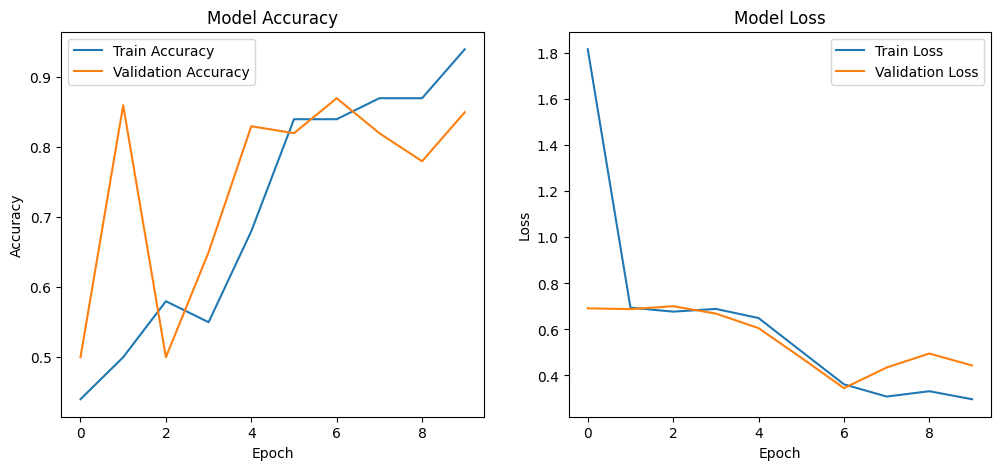

In [ ]:


# Plot training & validation accuracy
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 543ms/step


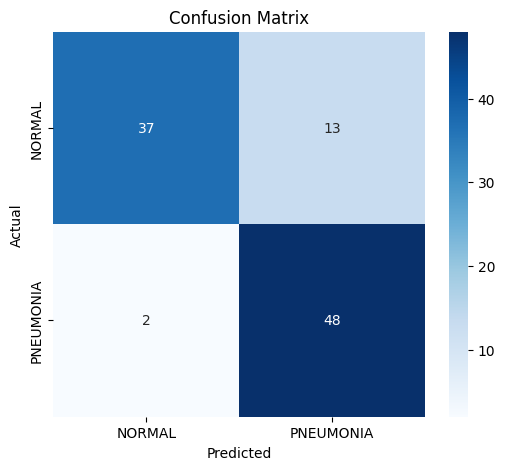

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Predict classes
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['NORMAL', 'PNEUMONIA'],
            yticklabels=['NORMAL', 'PNEUMONIA'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred_classes, target_names=['NORMAL', 'PNEUMONIA'])
print("Classification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

      NORMAL       0.95      0.74      0.83        50
   PNEUMONIA       0.79      0.96      0.86        50

    accuracy                           0.85       100
   macro avg       0.87      0.85      0.85       100
weighted avg       0.87      0.85      0.85       100



In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt


In [ ]:
def get_gradcam(model, img_array, class_index, layer_name=None):
    """
    Generate Grad-CAM heatmap for a single image.
    """
    if layer_name is None:
        # Use last conv layer automatically
        for layer in reversed(model.layers):
            if 'conv' in layer.name:
                layer_name = layer.name
                break

    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_index]

    # Gradient of the output neuron w.r.t convolution layer output
    grads = tape.gradient(loss, conv_outputs)

    # Guided Grad-CAM
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = np.maximum(heatmap, 0)  # ReLU
    heatmap /= np.max(heatmap) + 1e-8  # normalize
    return heatmap.numpy()


In [ ]:
def overlay_heatmap(img, heatmap, alpha=0.4, colormap=cv2.COLORMAP_JET):
    """
    Overlay heatmap on image.
    """
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, colormap)

    if len(img.shape) == 2:  # grayscale
        img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    else:
        img_color = img

    overlayed = cv2.addWeighted(heatmap_color, alpha, img_color, 1 - alpha, 0)
    return overlayed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


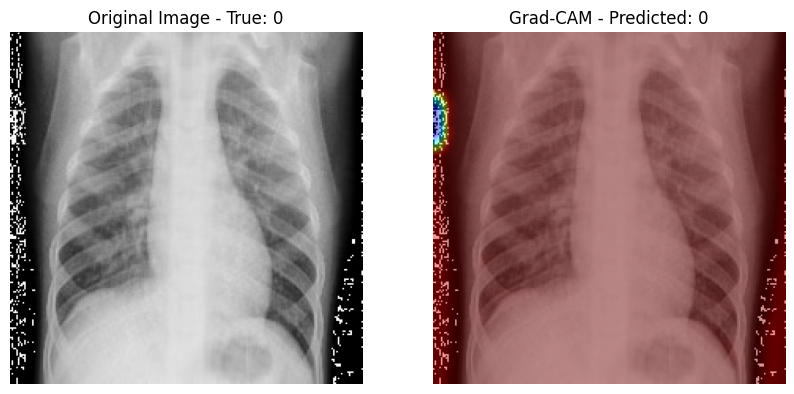

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

# -----------------------------
# 1️⃣ Forward pass to initialize model layers
# This helps ensure the `model` object has its input/output shapes defined for `model.input_shape`
_ = model.predict(np.expand_dims(X_test[0], axis=0))

# -----------------------------
# 2️⃣ Grad-CAM function
def get_gradcam(model, img_array, class_index, layer_name=None):
    """
    Generate Grad-CAM heatmap for a single image.
    """
    if layer_name is None:
        # Automatically use last conv layer
        for layer in reversed(model.layers):
            if isinstance(layer, tf.keras.layers.Conv2D):
                layer_name = layer.name
                break

    # Define an input tensor for the Grad-CAM model
    # This input will be the starting point for tracing the graph
    gradcam_input = tf.keras.Input(shape=model.input_shape[1:])

    # Trace the layers of the original model with the new symbolic input
    x = gradcam_input
    conv_layer_output_tensor = None
    for layer in model.layers:
        x = layer(x) # Call each layer of the original model with the current symbolic tensor
        if layer.name == layer_name:
            conv_layer_output_tensor = x

    # The final output of the original model, derived from gradcam_input
    final_output_tensor = x

    # Construct the Grad-CAM model
    # Its inputs are `gradcam_input`, and its outputs are the intermediate conv layer output
    # and the final prediction output, all derived from `gradcam_input`.
    grad_model = tf.keras.models.Model(
        inputs=gradcam_input,
        outputs=[conv_layer_output_tensor, final_output_tensor]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_index]

    # Gradient of the output neuron w.r.t convolution layer output
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = np.maximum(heatmap, 0)

    # Normalize heatmap, handle division by zero
    if np.max(heatmap) > 0:
        heatmap /= np.max(heatmap)
    else:
        heatmap = np.zeros_like(heatmap) # If all zeros, keep it all zeros

    return heatmap # Removed .numpy() as heatmap is already a numpy array

# -----------------------------
# 3️⃣ Overlay heatmap on original image
def overlay_heatmap(img, heatmap, alpha=0.4, colormap=cv2.COLORMAP_JET):
    """
    Overlay heatmap on image.
    """
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, colormap)

    # Ensure img is 3-channel for cv2.addWeighted
    if len(img.shape) == 2:  # grayscale
        img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    else:
        img_color = img

    overlayed = cv2.addWeighted(heatmap_color, alpha, img_color, 1 - alpha, 0)
    return overlayed

# -----------------------------
# 4️⃣ Test on a sample image
sample_idx = np.random.randint(0, X_test.shape[0])
sample_img = X_test[sample_idx]
sample_label = y_test[sample_idx]

img_input = np.expand_dims(sample_img, axis=0)
pred_class = np.argmax(model.predict(img_input))

heatmap = get_gradcam(model, img_input, class_index=pred_class)
original_img = (sample_img.squeeze() * 255).astype(np.uint8)
overlayed_img = overlay_heatmap(original_img, heatmap)

# -----------------------------
# 5️⃣ Plot results
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(original_img, cmap='gray')
plt.title(f'Original Image - True: {sample_label}')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(overlayed_img)
plt.title(f'Grad-CAM - Predicted: {pred_class}')
plt.axis('off')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


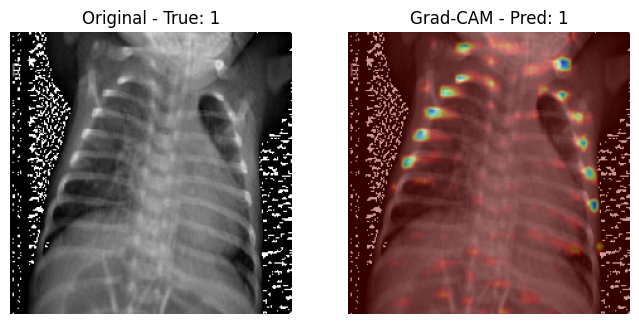

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


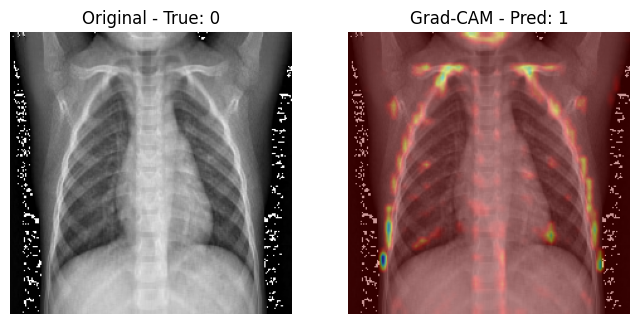

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


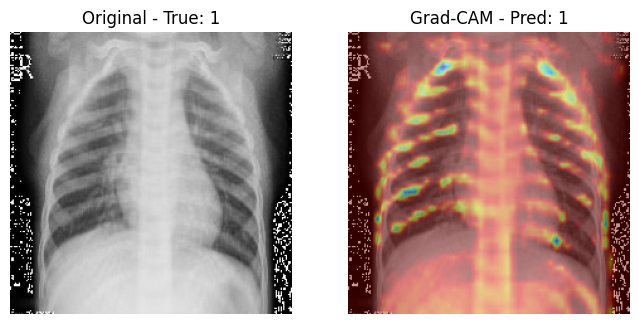

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


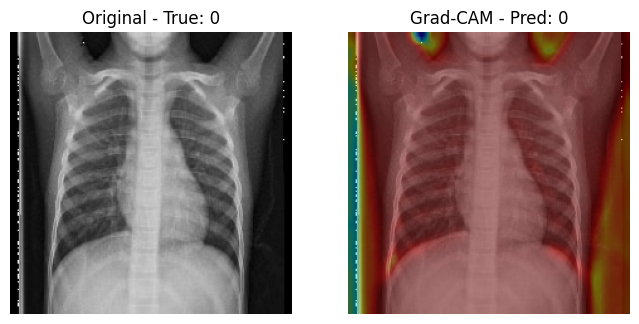

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


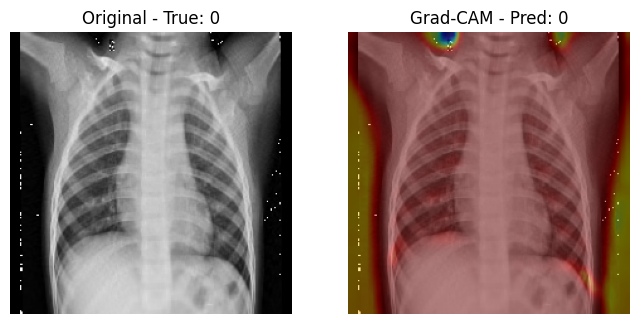

In [ ]:
for i in range(5):
    sample_idx = np.random.randint(0, X_test.shape[0])
    sample_img = X_test[sample_idx]
    sample_label = y_test[sample_idx]

    img_input = np.expand_dims(sample_img, axis=0)
    pred_class = np.argmax(model.predict(img_input))

    heatmap = get_gradcam(model, img_input, class_index=pred_class)
    original_img = (sample_img.squeeze() * 255).astype(np.uint8)
    overlayed_img = overlay_heatmap(original_img, heatmap)

    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(original_img, cmap='gray')
    plt.title(f'Original - True: {sample_label}')
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(overlayed_img)
    plt.title(f'Grad-CAM - Pred: {pred_class}')
    plt.axis('off')
    plt.show()


STREALIT

In [ ]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
import numpy as np
import cv2
from PIL import Image

# -----------------------------
# Load trained model (cached)
# -----------------------------
@st.cache_resource
def load_xray_model():
    return tf.keras.models.load_model('/content/drive/MyDrive/hackathon/model.keras')

model = load_xray_model()
labels = ["Normal", "Pneumonia"]

# -----------------------------
# SVD Preprocessing function
# -----------------------------
def apply_svd(img_gray, k=40):
    img_gray = img_gray.astype(np.float32) / 255.0
    U, S, Vt = np.linalg.svd(img_gray, full_matrices=False)
    img_svd = np.dot(np.dot(U[:, :k], np.diag(S[:k])), Vt[:k, :])
    img_svd = np.clip(img_svd, 0, 1)
    img_svd = (img_svd * 255).astype(np.uint8)
    return img_svd

# -----------------------------
# Streamlit UI
# -----------------------------
st.title("DeepTech Chest-Xray AI 🩺 (SVD + XAI)")
uploaded = st.file_uploader("Upload Lung X-ray", ["png","jpg","jpeg"])

if uploaded:
    # Open Image → Convert to array → Resize
    img = Image.open(uploaded).convert("L")
    img = np.array(img)
    img = cv2.resize(img, (224,224))

    # Apply SVD compression
    img_svd = apply_svd(img, k=40)

    # Prepare input for CNN
    x_input = img_svd.astype(np.float32)/255.0
    x_input = np.expand_dims(x_input, (0,-1))

    # Model prediction
    pred = model.predict(x_input)[0]
    class_idx = int(pred.argmax())
    confidence = float(pred.max())

    # Display images and result
    st.image(img, caption="Original Image", use_container_width=True)
    st.image(img_svd, caption="SVD Processed", use_container_width=True)

    st.success(f"**Prediction:** {labels[class_idx]}")
    st.info(f"**Confidence:** {confidence*100:.2f}%")

    # Simple explainability text
    st.write("### 🧠 What happened inside?")
    st.write(
        "The image was compressed using Singular Value Decomposition (SVD) "
        "to keep the most important features. Then the CNN analyzed the lungs "
        "and predicted whether infection signs look like pneumonia or normal lung."
    )

    st.warning("⚠️ This is an AI interpretation and not medical advice.")


Writing app.py


In [ ]:
!pip install pyngrok
from pyngrok import ngrok
import os

# Set your token
NGROK_TOKEN = "35xehyU4lwiKFWCOk4waESUeiqP_2y5miUPxc8UQ4nxi9uvMy"
os.environ["NGROK_AUTH_TOKEN"] = NGROK_TOKEN
ngrok.set_auth_token(NGROK_TOKEN)

print("Ngrok installed and token set ✅")


Ngrok installed and token set ✅


In [ ]:
!ngrok authtoken 35xehyU4lwiKFWCOk4waESUeiqP_2y5miUPxc8UQ4nxi9uvMy


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
from pyngrok import ngrok
import os

# Kill any previous tunnels
ngrok.kill()

# Run Streamlit app in background
os.system("streamlit run app.py &")

# Create public URL
public_url = ngrok.connect(8501)
print("Your public Streamlit URL:", public_url)


Your public Streamlit URL: NgrokTunnel: "https://intergyral-prediastolic-quentin.ngrok-free.dev" -> "http://localhost:8501"


In [ ]:
!pip install streamlit pyngrok opencv-python-headless

from pyngrok import ngrok
import os

ngrok.kill()
os.system("streamlit run app.py &")

public_url = ngrok.connect(8501)
print("Your public Streamlit URL:", public_url)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 110.0 MB/s eta 0:00:00
Your public Streamlit URL: NgrokTunnel: "https://intergyral-prediastolic-quentin.ngrok-free.dev" -> "http://localhost:8501"
